# Applied Machine Learning Coursework

- To be completed by **5pm** on **6th December** and uploaded to the coursework submission point on Moodle.

# Preamble/Predefined code

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def synthetic_data(m=300):
    Xh = np.vstack([np.random.randn(m // 3, 2) + np.array([1, 0]),
                    np.random.randn(m // 3, 2) + np.array([-3, -1]),
                    np.random.randn(m // 3, 2) + np.array([3, -3])])
    Y = np.vstack([np.ones((m // 3, 1)) @ np.array([[1, 0, 0]]),
                   np.ones((m // 3, 1)) @ np.array([[0, 1, 0]]),
                   np.ones((m // 3, 1)) @ np.array([[0, 0, 1]])])
    return Xh, Y


def extend_X(Xh):
    X = np.ones((Xh.size // Xh.shape[-1], Xh.shape[-1] + 1))
    X[:, 1:] = Xh
    return X


def plot_2D_data(Xh, Y, Theta=0):
    X1, X2 = np.meshgrid(np.linspace(-8, 8, 99), np.linspace(-8, 8, 99))
    Xgrid = np.vstack([X1.ravel(), X2.ravel()]).T
    try:
        Ypred = h(Xgrid, Theta)
    except:
        Ypred = 0.5 * np.ones((Xgrid.shape[0], Y.shape[1]))
    plt.figure(figsize=(10, 10))
    for k in range(Y.shape[1]):
        plt.subplot(2, int(np.ceil(Y.shape[1] / 2)), k + 1)
        plt.contourf(X1, X2, Ypred[:, k].reshape(X1.shape), cmap='gray')
        for j in range(Y.shape[1]):
            plt.scatter(Xh[np.argmax(Y, axis=1) == j, 0], Xh[np.argmax(Y, axis=1) == j, 1], label=f"class {j}")
        plt.title("$h_{θ_{" + str(k) + "}}$")
        plt.xlabel("$\hat x_1$")
        plt.ylabel("$\hat x_2$")
        plt.legend()
    plt.show()


# Q1

In [11]:
#Q1
def softmax(W):
    P = np.zeros(np.shape(W))  #Creates empty array
    for i in range(0, np.shape(W)[0]):  #Iterates over rows of W as calculations are only dependent on row values
        i_exp_row = np.exp(W[i])  #Creates an array {exp(W_{i,k}} 0 <= k < K-1
        i_row_sum = np.sum(i_exp_row)  #Finds sum for denominator
        P[i] = i_exp_row / i_row_sum  #Element-wise divides i_exp_row by sum
    return P

# Q2

In [22]:
#Q2
def h(Xh, Theta):
    return softmax(extend_X(Xh) @ Theta)

# Q3

In [56]:
#Q3
def loss(Xh, Theta, Y):
    return (-1 / np.shape(Y)[0]) * np.sum(np.multiply(Y, np.log(h(Xh, Theta))))

# Q4

In [57]:
#Q4
def grad_loss(Xh, Theta, Y):
    return (1 / np.shape(Xh)[0]) * extend_X(Xh).T@(h(Xh,Theta) - Y)

# Q5

In [61]:
#Q5
def data_split(X,Y,Mtest=50):
    I = np.arange(0,np.shape(X)[0]) #creates index array
    np.random.shuffle(I) #shuffles index array
    Itest,Itrain = I[:Mtest],I[Mtest:] #splits I into Itest, Itrain
    Xtrain, Ytrain, Xtest, Ytest = X[Itrain],Y[Itrain], X[Itest], Y[Itest] #Creates Xtrain,Ytrain,Xtest,Ytest
    return (Xtrain,Ytrain,Xtest,Ytest)

# Q6

In [62]:
#Q6
def gd(Xtrain,Ytrain,Xtest,Ytest,Theta0,t=1,p=100,q=0.99,S=1000):
    #initialising variables based on func input
    Theta_s = Theta0 #tracks current Theta value
    Theta_best = Theta0 #Tracks best Theta value
    s_best = 0
    testLossList = [] #Keeps record of test losses recorded

    for s in range(0,S): #Loops through integers (0,S-1)
        currentTestLoss = loss(Xtest,Theta_s,Ytest) #calculates test loss based on current Theta_s value. Theta_s will have been updated at end of previous loop
        testLossList.append(currentTestLoss)
        if currentTestLoss < min(testLossList): #updates Theta_best if neccessary
            Theta_best = Theta_s
            s_best = s
        if (s>=p) and (testLossList[s] > q*testLossList[s-p]): #Algorithm break condition
            break
        G = grad_loss(Xtrain,Theta_s,Ytrain) #Calculates gradient
        Theta_s = Theta_s - t*G #Updates Theta_s by step in gradient
    return (Theta_best,s_best,np.array(testLossList)) #Required values to be returned

# Q7

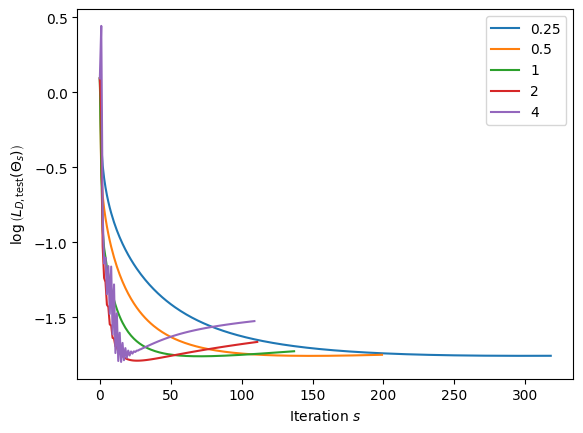

In [97]:
#Q7
#Generating Data
Xh,Y = synthetic_data()
XTrain,YTrain,XTest,YTest = data_split(Xh,Y)

t_list = [0.25,0.5,1,2,4]
Theta_0 = np.zeros((3,3))
for t in t_list:
    Theta_best,s_best,lossList = gd(XTrain,YTrain,XTest,YTest,Theta0=Theta_0,t=t,S=10**4)
    plt.plot(np.arange(np.shape(lossList)[0]),np.log(lossList))
#plt.yscale('log')
plt.xlabel(r'Iteration $s$')
plt.ylabel(r'$\log\left(L_{D,\text{test}}(\Theta_s)\right)$')
plt.legend(t_list)
plt.show()

# Q8

In [108]:
#Q8
#Loading data
Data = np.load('CW.npz')
Xh = Data['Xh']
Y = Data['Y']
Xhnew = Data['Xhnew']

#PCA Function
def PCA(X,r):
    A = (1/np.shape(X)[0])*X.T@X #Calculates A matrix
    Lambda, evecs = np.linalg.eigh(A) #Obtains evals and evecs of A
    r_ind = np.argpartition(Lambda,-r)[-r:] #finds indices of r largest evals
    sorted_indices = r_ind[np.argsort(Lambda[r_ind])][::-1] #orders the indices for niceness (largest to smallest)
    U = np.zeros((np.shape(evecs)[0],r)) #initialises U to correct shape
    for i in range(0,r): #makes columns of U the evecs with the largest evals
        U[:,i] = evecs[sorted_indices[i]]
    return U #returns U matrix

U = PCA(Xh,r=3) #Obtains U using PCA for Xh matrix and r=3

Zh = Xh@U #Generates Zh as required
Zhnew = Xhnew@U #Generates Zhnew as required

(1089, 3)


# Q9

In [ ]:
#Q9
#Data Prep
ZTrain,YTrain,ZTest,YTest = data_split(Zh,Y,Mtest=50)

# Unit Tests Below

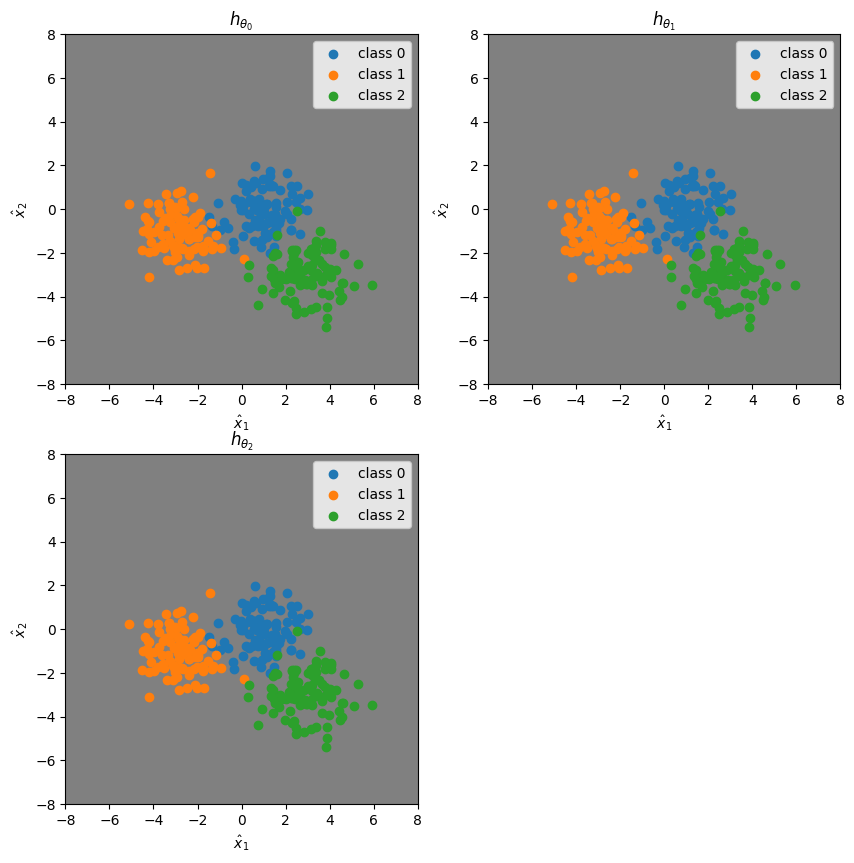

In [35]:
def test_h1():
    Xh = np.array([[1]])
    Theta = np.array([[0.5], [1]])
    assert np.abs(h(Xh, Theta) - 1) < 1e-7, "test_h1 detected a wrong h value"


def test_loss1():
    Xh = np.array([[1]])
    Theta = np.array([[0.5], [1]])
    Y = np.array([[1]])
    assert np.abs(loss(Xh, Theta, Y)) < 1e-7, "test_loss1 detected a wrong loss value"


def test_grad1():
    Xh = np.array([[1]])
    Theta = np.array([[0.5], [1]])
    Y = np.array([[1]])
    assert np.linalg.norm(grad_loss(Xh, Theta, Y)) < 1e-7, "test_grad1 detected a wrong gradient value"


def test_h2():
    Xh = np.array([[-1]])
    Theta = np.array([[1, 0, 0], [1, 0, 0]])
    assert np.linalg.norm(h(Xh, Theta) - np.ones((1, 3)) / 3) < 1e-7, "test_h2 detected a wrong h value"


def test_loss2():
    Xh = np.array([[-1]])
    Theta = np.array([[1, 0, 0], [1, 0, 0]])
    Y = np.array([[0.5, 0, 0.5]])
    assert np.abs(loss(Xh, Theta, Y) - np.log(3)) < 1e-7, "test_loss2 detected a wrong loss value"


def test_grad2():
    Xh = np.array([[-1]])
    Theta = np.array([[1, 0, 0], [1, 0, 0]])
    Y = np.array([[0.5, 0, 0.5]])
    G_exact = np.array([[-1 / 6, 1 / 3, -1 / 6], [1 / 6, -1 / 3, 1 / 6]])
    assert np.linalg.norm(grad_loss(Xh, Theta, Y) - G_exact) < 1e-7, "test_grad2 detected a wrong gradient value"


def test_h3():
    Xh = np.array([[1, 0], [0, 1]])
    Theta = np.array([[1, 0], [0, 1], [0, 1]])
    assert np.linalg.norm(h(Xh, Theta) - np.ones((2, 2)) / 2) < 1e-7, "test_h3 detected a wrong h value"


def test_loss3():
    Xh = np.array([[1, 0], [0, 1]])
    Theta = np.array([[1, 0], [0, 1], [0, 1]])
    Y = np.array([[0, 1], [0.25, 0.75]])
    assert np.abs(loss(Xh, Theta, Y) + np.log(0.5)) < 1e-7, "test_loss3 detected a wrong loss value"


def test_grad3():
    Xh = np.array([[1, 0], [0, 1]])
    Theta = np.array([[1, 0], [0, 1], [0, 1]])
    Y = np.array([[0, 1], [0.25, 0.75]])
    G_exact = np.array([[3 / 8, -3 / 8], [1 / 4, -1 / 4], [1 / 8, -1 / 8]])
    assert np.linalg.norm(grad_loss(Xh, Theta, Y) - G_exact) < 1e-7, "test_grad3 detected a wrong gradient value"


Xh, Y = synthetic_data()
plot_2D_data(Xh, Y)

In [36]:
test_h1()
test_h2()
test_h3()
test_loss1()
test_loss2()
test_loss3()
test_grad1()
test_grad2()
test_grad3()